In [6]:
import os
import sumolib
from routing_lib import from_sumo_to_igraph_network
from meru import get_map_shape

output_folder = './drive/MyDrive/SimulationOutputs/'

os.makedirs(output_folder, exist_ok=True)
root = os.getcwd()

result_dict = {}

# EXTRACTING INFO FROM THE THREE NETWORKS

for city in ['florence', 'rome', 'milan_big']:
    road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
    mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

    road_network = sumolib.net.readNet(road_network_path, withInternal=False)
    G = from_sumo_to_igraph_network(road_network)
    
    # Raw Shape of network location
    map_shape = get_map_shape(G)

    # Projecting on Italy: EPSG:3004 is centered on Italy
    area_km2 = map_shape.to_crs(epsg=3004).geometry.area.iloc[0] / 10**6
    
    result_dict[city] = (len(road_network.getNodes()), len(road_network.getEdges()), sum(G.es['length']), area_km2)

# Get RoadNetworks Info

In [9]:
import pandas as pd

df = pd.DataFrame(result_dict).T
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df[2] = df[2] / 10**3
df.columns = ('Vertices', 'Edges', 'Road Length', 'Area (KM^2)')
df['Density'] = df['Road Length'] / df['Area (KM^2)']

df.index = [x[0].upper()+x[1:].lower().replace('_big', '') for x in df.index]
df

,Vertices,Edges,Road Length,Area (KM^2),Density
Florence,6140,11804,1050.33085,113.521951,9.252227
Rome,31798,63384,6568.99448,778.359567,8.439537
Milan,24063,46488,4339.90919,496.487978,8.741217


# Combine plots and CO2 measure reductions of all MERU parameters

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_co2_meru(sorted_df, log_scale=False):

    algo = 'MERU'

    groupby_algorithm_results = sorted_df['CO2 Tons'].groupby(sorted_df['fitted_vehicles'])
    scans = np.array(groupby_algorithm_results.mean().keys()) / 1000

    mean_value = groupby_algorithm_results.mean().values
    std_deviation = groupby_algorithm_results.std().values

    scan_mean = list(zip(scans, mean_value))
    scan_mean.sort(key=lambda x: x[0])
    x, y = zip(*scan_mean)

    if log_scale:
        x_interp = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp = np.interp(x_interp, np.log(x), np.log(y))
        x_interp = np.exp(x_interp)
        y_interp = np.exp(y_interp)
    else:
        x_interp = np.linspace(min(x), max(x), num=100)
        y_interp = np.interp(x_interp, x, y)

    plt.scatter(x, y, marker='p')
    plt.plot(x_interp, y_interp, label=f'{algo}: CO2 Tons Mean')

    scan_std = list(zip(scans, std_deviation))
    scan_std.sort(key=lambda x: x[0])
    x, y = zip(*scan_std)

    if log_scale:
        x_interp_std = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp_std = np.interp(x_interp_std, np.log(x), np.log(y))
        x_interp_std = np.exp(x_interp_std)
        y_interp_std = np.exp(y_interp_std)
    else:
        x_interp_std = np.linspace(min(x), max(x), num=100)
        y_interp_std = np.interp(x_interp_std, x, y)

    plt.fill_between(x_interp, y_interp - y_interp_std, y_interp + y_interp_std, color='red', alpha=0.3, label=f'{algo}: CO2 Tons Std')

    if log_scale:
        plt.xscale('log')

Reduction in CO2 (mean) (std)
florence best baseline is GR_delta02_tau02 : 	CO2 AVG = 36.56 CO2 STD = 1.58
florence use case is MERU5000 : 		CO2 AVG = 28.64 CO2 STD = 1.25
florence	0.14	0.14
rome best baseline is KMD_epsilon03 : 	CO2 AVG = 117.00 CO2 STD = 2.37
rome use case is MERU30000 : 		CO2 AVG = 112.45 CO2 STD = 7.36
rome		-0.0	0.06
milan_big best baseline is KMD_epsilon03 : 	CO2 AVG = 107.39 CO2 STD = 1.60
milan_big use case is MERU15000 : 		CO2 AVG = 91.26 CO2 STD = 3.42
milan_big	0.14	0.03


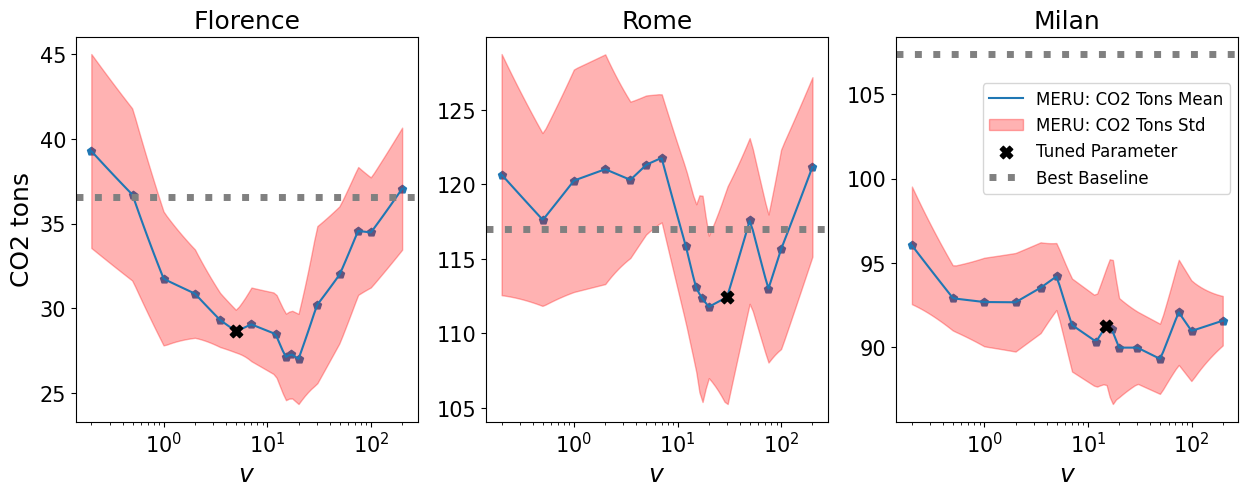

In [11]:
# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))
print('Reduction in CO2 (mean) (std)')

for n, city in enumerate(['florence', 'rome', 'milan_big']):
    plt.subplot(1, 3, n+1)  # 1 row, 3 columns, ith plot
    
    if n == 0:
        plt.ylabel('CO2 tons', fontsize = 18)
    
    log = True
    
    # SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
    chosen_map = {'florence' : 5000,
                  'milan_big' : 15000,
                  'rome' : 30000}

    fitted_vehicles = chosen_map[city]
    
    results_dist = {}
    results_dist['measures'] = pd.read_csv(f'./drive/MyDrive/SimulationOutputs/{city} 1/{city}_distributions_simulation_results.csv')

    df = pd.read_csv(f'./drive/MyDrive/SimulationOutputs/{city} 1/simulation_results.csv')
    meru_records = df['algorithm_name'].str.contains('MERU')
    seru_records = df['algorithm_name'].str.contains('SERU')
    
    without_eru = df[~meru_records & ~seru_records]
    grouped_avg = without_eru.groupby('algorithm_name')['CO2 Tons'].mean()

    # Find the value of A with the lowest average value of CO2 Tons
    best_baseline = grouped_avg.idxmin()
    
    print(city, 'best baseline is', best_baseline, end = ' : \t')
    res = df[df['algorithm_name'] == best_baseline]
    print(f"CO2 AVG = {res['CO2 Tons'].mean():.2f}",
          f"CO2 STD = {res['CO2 Tons'].std():.2f}")
    
    
    df_algo = results_dist['measures'][results_dist['measures']['algorithm_name'].str.contains('MERU')]
    df_algo['fitted_vehicles'] = df_algo['algorithm_name'].str.replace('MERU', '').astype(int)
    sorted_df = df_algo.sort_values(by=['fitted_vehicles', 'random_state'], ascending=[True, True])
    
    plot_co2_meru(sorted_df, log_scale=log)
    parameter_fitting_result_co2 = sorted_df[sorted_df['fitted_vehicles'] == fitted_vehicles]['CO2 Tons']
    
    print(city, 'use case is', f'MERU{fitted_vehicles}', end = ' : \t\t')
    print(f'CO2 AVG = {parameter_fitting_result_co2.mean():.2f}', 
          f'CO2 STD = {parameter_fitting_result_co2.std():.2f}')
    plt.scatter([fitted_vehicles / 1000], parameter_fitting_result_co2.mean(), marker = 'X', s = 80, color = 'black', label = f'Tuned Parameter', zorder = 10)

    plt.axhline(y=res['CO2 Tons'].mean(), linewidth=5, linestyle='dotted', color='gray', label='Best Baseline')
    plt.title(f'{city[0].upper()}{city[1:].replace("_big", "")}', fontsize = 18)
    plt.xlabel('$v$', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    mean_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).mean(), 2)
    std_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).std(), 2)
    
    print(city+'\t' if city == 'rome' else city, mean_x, std_x, sep = '\t')

# plt.suptitle(f'CO2 Tons w/ different parameters on cities', fontsize = 18)
# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize = 12)

# Show the plot
plt.show()
